In [1]:
from torch import nn
import torch

In [2]:
from torch.nn.utils.rnn import pad_sequence

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import os

In [6]:
from einops import rearrange

In [7]:
import random

In [8]:
from torch.utils.data import DataLoader

In [9]:
import torchvision.transforms as T

In [10]:
from skimage.util import random_noise

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [12]:
import torchaudio

C:\Users\aag12\anaconda3\envs\ml_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [13]:
from sklearn import preprocessing

In [14]:
from sklearn.model_selection import train_test_split

In [54]:
from tqdm import tqdm

In [226]:
from tqdm import tqdm
import torch.optim as optim

# Defining Dataseat

In [55]:
from datasets import load_dataset

In [56]:
from datasets import disable_caching
disable_caching()

In [57]:
# good_files = []
# for i in range(1, 6):
#     new_files = [f"0{i}/{fname.replace('npy', '')}mp3" for fname in os.listdir(f"../../subset_moodtheme/0{i}")]
#     good_files.extend(new_files)

# test_files = [f"00/{fname.replace('npy', '')}mp3" for fname in os.listdir("../../subset_moodtheme/00")]
# print(good_files)
# print(test_files)

In [58]:
with open("goodfiles.txt", 'r') as f:
    all_files = f.readlines()
all_files = [g.strip().replace("npy", 'mp3') for g in all_files if len(g.strip()) > 0]

In [59]:
all_files[:3]

['01/846501.mp3', '34/1288334.mp3', '98/1082098.mp3']

In [60]:
good_files, test_files = train_test_split(all_files, test_size=0.2)

In [61]:
len(good_files), len(test_files)

(2200, 551)

In [62]:
def files_to_labels(files):
    col_names = ['TRACK_ID',
     'ARTIST_ID',
     'ALBUM_ID',
     'PATH',
     'DURATION',
     'TAGS',
     'TAGS2',
     'TAGS3',
     'TAGS4',
     'TAGS5',
     'TAGS6',
     'TAGS7',
     'TAGS8',
     'TAGS9']
    MOODPATH = "../../../Downloads/autotagging_moodtheme.tsv.txt"
    df = pd.read_csv(MOODPATH, sep='\t', names=col_names)
    df = df[df["PATH"].isin(files)]
    inds = {'fast': 0,
     'sexy': 1,
     'mellow': 2,
     'heavy': 3,
     'horror': 4,
     'travel': 5,
     'holiday': 6,
     'groovy': 7,
     'funny': 8,
     'retro': 9,
     'hopeful': 10,
     'powerful': 11,
     'cool': 12,
     'nature': 13,
     'game': 14}

    final_labels = []
    for i in range(len(df)):
        curr = np.zeros(len(inds))
        moods = list(df.iloc[i])[5:]
        for theme in moods:
            if type(theme) == str and "mood" in theme:
                check = theme.split("---")[-1]
                if check in inds:
                    curr[inds[check]] = 1
            else:
                pass

        final_labels.append(curr)
    return final_labels

In [63]:
train_labels = files_to_labels(good_files)

In [64]:
test_labels = files_to_labels(test_files)

In [65]:
train_labels[:2]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])]

In [66]:
# train_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in good_files]
# test_np_files = [("../../subset_moodtheme/" + g).replace(".mp3", ".npy") for g in test_files]
train_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in good_files]
test_np_files = ["../../mtg-jamendo-dataset/all_data/" + g.replace("mp3", "npy") for g in test_files]

In [67]:
train_np_files[:2], test_np_files[:2]

(['../../mtg-jamendo-dataset/all_data/50/783250.npy',
  '../../mtg-jamendo-dataset/all_data/51/572351.npy'],
 ['../../mtg-jamendo-dataset/all_data/49/684249.npy',
  '../../mtg-jamendo-dataset/all_data/52/361552.npy'])

In [68]:
import time

In [637]:
# SEQ_LEN = 10000
SEQ_LEN = 3000
# SEQ_LEN = 5000

## Super Dumb Model

In [638]:
from torchvision import transforms

In [712]:
class FinetuningMusicDataset(torch.utils.data.Dataset):   
    def __init__(self, np_file_paths, labels, transforms, seq_len=10000, random_start=True, upsample_factor=10):
        self.seq_len = seq_len
        self.files = np_file_paths
        self.labels = labels
        self.transforms = transforms
        self.random_start = random_start
        self.upsample_factor = upsample_factor
    def __len__(self):
        return len(self.files) * self.upsample_factor

    def __getitem__(self, index):
        effective_index = index % len(self.files)
        x = np.load(self.files[effective_index])
        x = torch.from_numpy(x).float()
        if self.random_start and x.shape[-1] > self.seq_len:
            # longer than 3000, select random subset
            start = random.randint(0, x.shape[-1] - self.seq_len)
            x = x[:,start:start+self.seq_len]
        else:
            x = x[:,:self.seq_len]
        old_x = x.unsqueeze(0)
        
        compressed_x = (torch.clamp(old_x, min=-90, max=30) + 90) / 120
        
        x = self.transforms(compressed_x)
        
        item = {"input": x, "label_ids":[index], "labels": torch.tensor(self.labels[effective_index])}
        
        return item

In [713]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [714]:
noise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.Normalize((0.5542), (0.1604)),
    AddGaussianNoise(0., 0.04)
])
nonoise_composed = transforms.Compose([
   transforms.Resize((224, 224)),
    transforms.Normalize((0.5542), (0.1604))
#     transforms.Resize((500, 500)),
])

In [715]:
# all_train = []
# for t in train_np_files:
#     d = np.load(t)
#     d = torch.tensor(d)
#     d = d.unsqueeze(0)
#     r = transforms.Resize((224, 224))(d)
#     new_r = (torch.clamp(r, min=-90, max=30) + 90) / 120
#     all_train.append(new_r)

In [716]:
# len(all_train)

In [717]:
# torch.cat(all_train).mean(), torch.cat(all_train).std()

In [718]:
# transforms.Normalize((0.5542), (0.1604))(new_r)

In [719]:
# (torch.clamp(r, min=-90, max=30) + 90) / 120

In [720]:
ft_train_dataset = FinetuningMusicDataset(train_np_files, train_labels, noise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=5)
ft_test_dataset = FinetuningMusicDataset(test_np_files, test_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=False, upsample_factor=1)

In [721]:
batch_size=16

In [722]:
ft_train_dl = DataLoader(
    ft_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

ft_test_dl = DataLoader(
    ft_test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [723]:
c = nn.Conv2d(1, 3, kernel_size=5, stride=(3, 1), padding=0)

In [724]:
start = torch.rand(1, 1, 500, 500)

In [725]:
start.shape

torch.Size([1, 1, 500, 500])

In [726]:
c(start).shape

torch.Size([1, 3, 166, 496])

In [727]:
c2 = nn.Conv2d(3, 1, kernel_size=5, stride=(3, 3), padding=0)

In [728]:
c2(c(start)).shape

torch.Size([1, 1, 54, 164])

In [729]:
24 * 72

1728

In [730]:
# model = torch.nn.Sequential(
#     nn.Flatten(),
# #     nn.Linear(250000, 512),
#     nn.Linear(50176, 512),
#     nn.LeakyReLU(),
#     nn.Dropout(0.1)
# )

# model = torch.nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(50176, 1024),
#     nn.Dropout(0.1),
# #     nn.Linear(54 * 164, 1024),
#     nn.LeakyReLU(),
# #     nn.Dropout(0.1),
#     nn.Linear(1024, 512),
#     nn.LeakyReLU(),
#     nn.Dropout(0.1)
# )

In [731]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [732]:
model = model.to(device)

In [733]:
heads = [nn.Sequential(nn.Linear(512, 512), nn.LeakyReLU(), nn.Linear(512, 1)) for i in range(15)]

In [734]:
heads = [h.to(device) for h in heads]

In [735]:
# pos_weight = 1 / (torch.sum(torch.tensor(train_labels), dim=0) / len(train_labels))
pos_weight = 1 / (torch.sum(torch.tensor(test_labels), dim=0) / len(test_labels))

In [736]:
pos_weight

tensor([27.5500, 23.9565, 15.7429, 19.0000, 14.8919, 15.7429, 15.3056, 14.8919,
        14.5000, 13.7750, 12.8140, 13.4390, 10.0182,  9.8393,  9.8393],
       dtype=torch.float64)

In [737]:
# optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=0.05, betas=(0.9, 0.95))
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=0.05, betas=(0.9, 0.95))
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight.to(device))

In [738]:
def get_total_loss(model, dataloader):
    total_loss = 0
    for batch_idx, data in enumerate(dataloader):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        outputs = torch.concat([h(outputs) for h in heads], dim=1)
        total_loss += criterion(outputs, labels.float())
    return total_loss.item()

In [739]:
model.train()
ft_train_losses = []
ft_test_losses = []
for epoch in range(10):
# for epoch in range(5):
    total_loss = 0
#     for batch in train_loader:
    for batch_idx, data in tqdm(enumerate(ft_train_dl), total=len(ft_train_dl)):
        these_losses = []
        optimizer.zero_grad()
        inputs, labels = data['input'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        outputs = torch.concat([h(outputs) for h in heads], dim=1)
        
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        # for bookkeeping
        total_loss += loss.item()
        
    with torch.no_grad():
        train_total_loss = total_loss
        test_loss = get_total_loss(model, ft_test_dl)
        ft_train_losses.append(train_total_loss)
        ft_test_losses.append(test_loss)
        print(f"Epoch: {epoch}; Loss: {train_total_loss}; Test Loss: {test_loss}")

_ = model.eval()

100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:15<00:00,  9.11it/s]


Epoch: 0; Loss: 4739.797083332047; Test Loss: 2888.208740234375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:13<00:00,  9.38it/s]


Epoch: 1; Loss: 2694.6315145370013; Test Loss: 5013.52490234375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:12<00:00,  9.51it/s]


Epoch: 2; Loss: 3154.5414133056206; Test Loss: 4930.10009765625


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:16<00:00,  8.98it/s]


Epoch: 3; Loss: 2526.483926955386; Test Loss: 3850.4521484375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:14<00:00,  9.22it/s]


Epoch: 4; Loss: 2539.823655427852; Test Loss: 3800.432861328125


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:13<00:00,  9.38it/s]


Epoch: 5; Loss: 2605.2551147603954; Test Loss: 3242.58935546875


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:17<00:00,  8.89it/s]


Epoch: 6; Loss: 2670.8615570126603; Test Loss: 3217.201904296875


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:14<00:00,  9.19it/s]


Epoch: 7; Loss: 2664.4630642275342; Test Loss: 3746.198974609375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:12<00:00,  9.49it/s]


Epoch: 8; Loss: 2646.5476412939047; Test Loss: 3628.9755859375


100%|████████████████████████████████████████████████████████████████████████████████████████| 688/688 [01:16<00:00,  9.05it/s]


Epoch: 9; Loss: 2579.4972847686477; Test Loss: 3555.541015625


Text(0.5, 1.0, 'MAE v1: Finetuning Train/Test Loss')

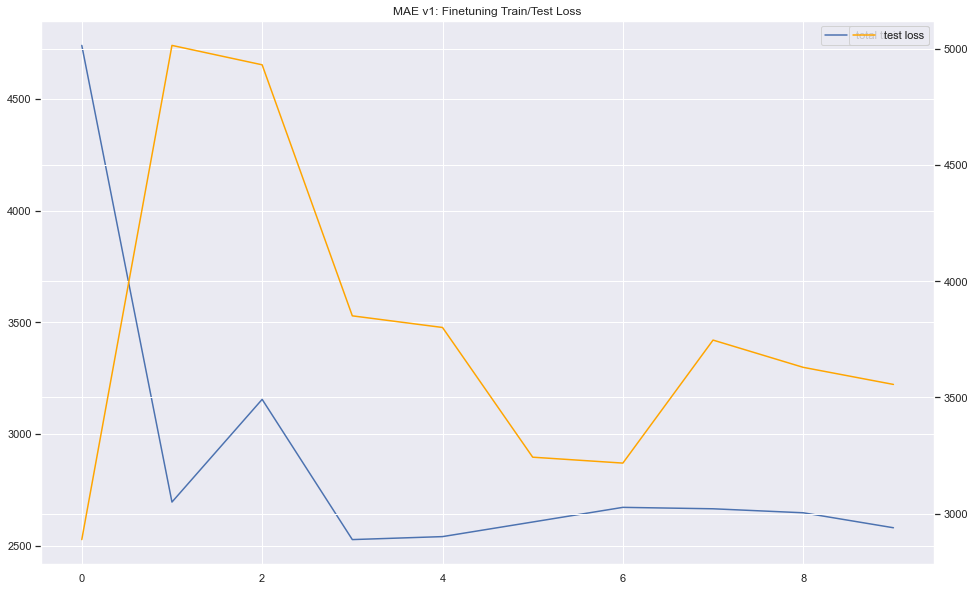

In [740]:
plt.figure(figsize=(16, 10))
ranger = list(range(len(ft_train_losses)))
sns.lineplot(x=ranger, y=ft_train_losses, label="total train loss", alpha=1)
# sns.lineplot(x=ranger, y=adjusted_train_losses, label="adjusted train loss")
ax2 = plt.twinx()
sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", ax=ax2, color="orange", alpha=1)
# sns.lineplot(x=ranger, y=ft_test_losses, label="test loss", color="orange", alpha=0.5)
plt.title("MAE v1: Finetuning Train/Test Loss")
# plt.savefig("mae_v1.png")

In [741]:
ft_trainnosample_dataset = FinetuningMusicDataset(train_np_files, train_labels, nonoise_composed, seq_len=SEQ_LEN, random_start=True, upsample_factor=1)

In [742]:
ft_train_eval_dl = DataLoader(
    ft_trainnosample_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
 )

In [743]:
import torch.nn.functional as F

In [744]:
inputs.shape

torch.Size([8, 1, 224, 224])

In [745]:
ft = torch.cat([ft_test_dataset[0]['input'], ft_test_dataset[1]['input'], ft_test_dataset[2]['input']])

In [746]:
ft

tensor([[[-2.1618, -1.7138, -1.0910,  ...,  0.2644,  0.8954,  0.8528],
         [-2.2165, -1.7538, -1.1410,  ...,  0.3398,  0.9601,  0.9209],
         [-2.3805, -1.8739, -1.2908,  ...,  0.5661,  1.1541,  1.1250],
         ...,
         [-2.6041, -1.7394, -2.7676,  ..., -2.8768, -2.8583, -2.8909],
         [-3.0006, -2.1107, -3.1830,  ..., -3.1366, -3.2540, -3.2450],
         [-3.1327, -2.2344, -3.3214,  ..., -3.2232, -3.3859, -3.3630]],

        [[ 0.4983,  0.9033, -0.3487,  ...,  0.7118,  0.4439,  1.0078],
         [ 0.4989,  0.8855, -0.3586,  ...,  0.7131,  0.4305,  1.0466],
         [ 0.5007,  0.8320, -0.3881,  ...,  0.7169,  0.3902,  1.1630],
         ...,
         [-1.7732, -2.0033, -1.6005,  ..., -0.9355, -0.9586, -0.7985],
         [-1.9305, -2.2169, -1.5112,  ..., -1.3635, -1.4280, -1.1643],
         [-1.9829, -2.2881, -1.4815,  ..., -1.5061, -1.5844, -1.2862]],

        [[ 1.5071, -0.1729,  0.6593,  ...,  1.1868,  0.5588,  0.9677],
         [ 1.5446, -0.0963,  0.6882,  ...,  1

In [750]:
ft.shape

torch.Size([3, 224, 224])

In [751]:
model(ft.unsqueeze(1).to(device))

tensor([[ -6.2683,  -9.3228, -29.8884,  ..., -12.5783, -13.3075, -10.9991],
        [ -4.2696,  -6.7793, -16.1107,  ...,  -9.8461,  -9.9517,  -6.3355],
        [ -8.8096,  -7.7522, -19.3843,  ..., -19.5715,  -9.1783,  -3.4315]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)

In [752]:
model.eval()
for h in heads:
    h.eval()

combined_preds = []
combined_labels = []

with torch.no_grad():
    total_correct = 0
    zero_correct = 0
    total_values = 0
    only_positives = [0, 0]
    for batch_idx, data in enumerate(ft_test_dl):
#     for batch_idx, data in enumerate(ft_train_eval_dl):
        inputs, labels = data['input'].to(device), data['labels'].to(device)

        outputs = model(inputs)
        outputs = torch.concat([h(outputs) for h in heads], dim=1)
        outputs = torch.sigmoid(outputs)
        
        combined_preds.append(outputs)
        combined_labels.append(labels)
        
        outlabels = torch.zeros_like(outputs)
        outlabels[outputs >= 0.5] = 1
        outlabels[outputs < 0.5] = 0
        
        num_correct = torch.sum(outlabels == labels).item()
        num = len(labels) * 15
        
        total_correct += num_correct
        total_values += num
        zero_correct += torch.sum(labels == 0).item()
        
        only_positives[0] += torch.sum(labels).item()
        only_positives[1] += torch.sum(labels[labels == 1] == outlabels[labels == 1]).item()
        

print(total_correct / total_values)

print(f"{total_correct} out of {total_values}")

print("Performance on positive labels")

print(only_positives[1] / only_positives[0])

print(f"{only_positives[1]} out of {only_positives[0]}")

print("WHAT IF WE JUST PREDICTED ZERO")

print(zero_correct / total_values)

print(f"{zero_correct} out of {total_values}")

0.5245009074410163
4335 out of 8265
Performance on positive labels
0.47676419965576594
277 out of 581.0
WHAT IF WE JUST PREDICTED ZERO
0.9297035692679976
7684 out of 8265


In [753]:
all_preds = torch.cat(combined_preds)
all_labels = torch.cat(combined_labels)
all_preds.shape, all_labels.shape

(torch.Size([551, 15]), torch.Size([551, 15]))

In [754]:
len(ft_test_dataset)

551

In [755]:
from sklearn import metrics

In [756]:
all_preds

tensor([[0.0718, 0.9693, 0.7051,  ..., 0.5147, 0.2806, 0.5417],
        [0.3435, 0.7405, 0.6251,  ..., 0.4832, 0.3126, 0.4968],
        [0.3802, 0.4915, 0.4302,  ..., 0.5173, 0.3640, 0.6169],
        ...,
        [0.3259, 0.4062, 0.4129,  ..., 0.5321, 0.3744, 0.4907],
        [0.0992, 0.8336, 0.3250,  ..., 0.2235, 0.2717, 0.3893],
        [0.2294, 0.5050, 0.4613,  ..., 0.6728, 0.2511, 0.6295]],
       device='cuda:0')

In [757]:
aucs = []
for i in range(15):
    preds = all_preds[:,i].cpu()
    targs = all_labels[:,i].cpu()
#     fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    fpr, tpr, thresholds = metrics.roc_curve(targs, preds, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    aucs.append(auc)
    print(f"Head: {i}; AUC: {auc}")

Head: 0; AUC: 0.5332862523540489
Head: 1; AUC: 0.5167160737812911
Head: 2; AUC: 0.5141749723145072
Head: 3; AUC: 0.4991742634429911
Head: 4; AUC: 0.5152750026290883
Head: 5; AUC: 0.5118493909191583
Head: 6; AUC: 0.5199568500539373
Head: 7; AUC: 0.48766957619097695
Head: 8; AUC: 0.49615266235764854
Head: 9; AUC: 0.48850293542074363
Head: 10; AUC: 0.45930232558139533
Head: 11; AUC: 0.5125059780009565
Head: 12; AUC: 0.45130131964809383
Head: 13; AUC: 0.5311327561327561
Head: 14; AUC: 0.5827200577200577
